In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sp
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# Data Reading

First we read the data and check if it worked.

In [2]:
df = pd.read_csv('daten.csv', delimiter=";",parse_dates=['Beginn Stunde'], index_col=0)

In [3]:
# df["Beginn Stunde"] = pd.to_datetime(df["Beginn Stunde"])
# df["Beginn Stunde"] = df["Beginn Stunde"].dt.strftime("%d-%m-%Y")
# df["Beginn Stunde"] = pd.to_datetime(df["Beginn Stunde"])

In [4]:
# df["Ende Stunde"] = pd.to_datetime(df["Ende Stunde"])
# df["Ende Stunde"] = df["Ende Stunde"].dt.strftime("%d-%m-%Y")
# df["Ende Stunde"] = pd.to_datetime(df["Ende Stunde"])

In [5]:
df.head()

,Ende Stunde,Stromspotpreise Deutschland [EUR/MWh],CO2 Preise [EUR/t],Gasspotpreise Deutschland [EUR/MWh],Stromverbrauch Deutschland [MW],Stromerzeugung Deutschland - Biomasse [MW],Stromerzeugung Deutschland - Braunkohle [MW],Stromerzeugung Deutschland - Gas [MW],Stromerzeugung Deutschland - Steinkohle[MW],Stromerzeugung Deutschland - Wasserkraft [MW],Stromerzeugung Deutschland - Nuklear [MW],Stromerzeugung Deutschland - Solar [MW],Stromerzeugung Deutschland - Wind Offshore [MW],Stromerzeugung Deutschland - Wind Onshore [MW]
Beginn Stunde,,,,,,,,,,,,,,
2018-01-07 00:00:00,01.07.2018 01:00,"33,3","14,95","21,89","42346,5","4464,5","11928,75","2374,25","1238,5","1826,5","8939,75",0,"2341,25","15277,5"
2018-01-07 01:00:00,01.07.2018 02:00,"26,42","14,95","21,89","40215,75","4460,25",11610,2367,"1193,5","1826,5","8950,25",0,2266,"14608,25"
2018-01-07 02:00:00,01.07.2018 03:00,"26,11","14,95","21,89","38870,5","4478,5","11073,25",2348,"1217,75",1816,"8918,5",0,2023,"14176,25"
2018-01-07 03:00:00,01.07.2018 04:00,"22,12","14,95","21,89","37833,5","4477,75","10498,25","2361,25","1281,75",1800,"8955,75",0,"1730,75","13418,25"
2018-01-07 04:00:00,01.07.2018 05:00,"23,42","14,95","21,89","37345,75","4490,5",10496,"2370,75","1284,5",1800,9003,"1,5","1490,75",12351


In [6]:
# plt.figure(figsize=(10, 6))
# plt.plot(df.index, df['Stromspotpreise Deutschland [EUR/MWh]'], label='Time Series Data')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Time Series Data')
# plt.legend()
# plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26304 entries, 2018-01-07 00:00:00 to 2021-06-30 23:00:00
Data columns (total 14 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   Ende Stunde                                      26304 non-null  object
 1   Stromspotpreise Deutschland [EUR/MWh]            26304 non-null  object
 2   CO2 Preise [EUR/t]                               26304 non-null  object
 3   Gasspotpreise Deutschland [EUR/MWh]              26304 non-null  object
 4   Stromverbrauch Deutschland [MW]                  26304 non-null  object
 5   Stromerzeugung Deutschland - Biomasse [MW]       26304 non-null  object
 6   Stromerzeugung Deutschland - Braunkohle [MW]     26304 non-null  object
 7   Stromerzeugung Deutschland - Gas [MW]            26304 non-null  object
 8   Stromerzeugung Deutschland - Steinkohle[MW]      26304 non-null  object
 9   Stro

In [8]:
df['Stromspotpreise Deutschland [EUR/MWh]'] = df['Stromspotpreise Deutschland [EUR/MWh]'].str.replace(',', '.')
df['Stromspotpreise Deutschland [EUR/MWh]'] = pd.to_numeric(df['Stromspotpreise Deutschland [EUR/MWh]'])
df['Stromspotpreise Deutschland [EUR/MWh]'][0]

33.3

# Time Series Analysis

First we do a basic Decomposition of Trend and Seasonality, for which we use an additive model.

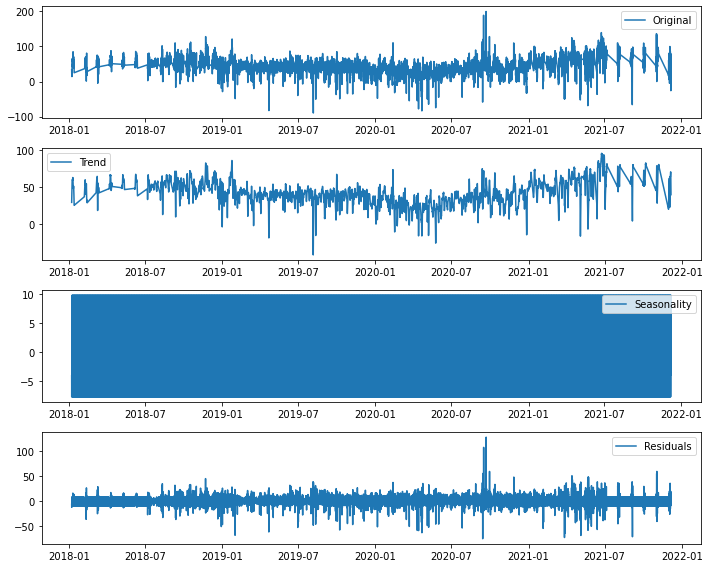

In [9]:
df.index = pd.to_datetime(df.index)
df = df[~df.index.duplicated(keep='first')].resample('H').interpolate()

decomposition = seasonal_decompose(df['Stromspotpreise Deutschland [EUR/MWh]'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(df['Stromspotpreise Deutschland [EUR/MWh]'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

One can see some small trends, depending on the time of the Year. For example, we can see downward pointing trends in the summer seasons.

But this did not give very satisfying results. Therefore we will take a closer look at daily, weekly and monthly data.

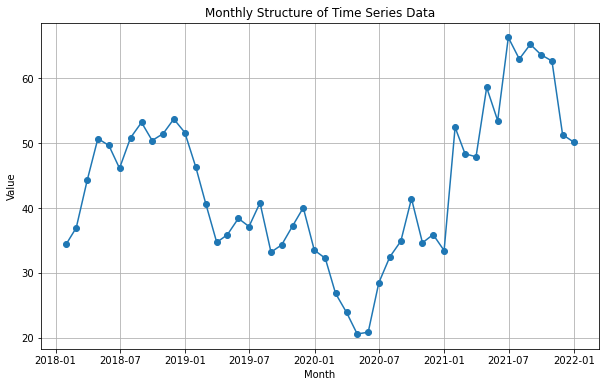

In [10]:
# Resample data to monthly frequency
df_monthly = df.resample('M').mean()  # You can use other aggregation methods like sum, median, etc., instead of mean

# Plot the monthly structure
plt.figure(figsize=(10, 6))
plt.plot(df_monthly.index, df_monthly['Stromspotpreise Deutschland [EUR/MWh]'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Monthly Structure of Time Series Data')
plt.grid(True)
plt.show()

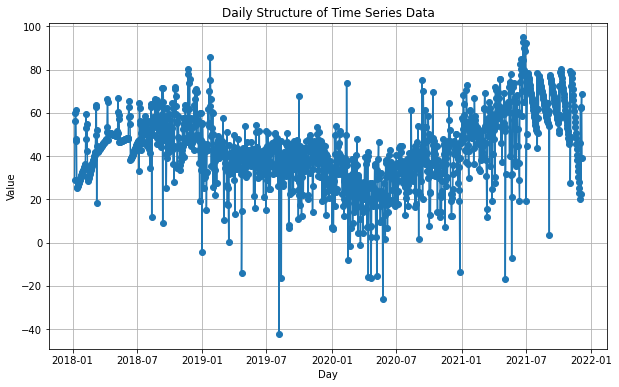

In [11]:
# Resample data to daily frequency
df_daily = df.resample('D').mean()  # You can use other aggregation methods like sum, median, etc., instead of mean

# Plot the daily structure
plt.figure(figsize=(10, 6))
plt.plot(df_daily.index, df_daily['Stromspotpreise Deutschland [EUR/MWh]'], marker='o', linestyle='-')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Daily Structure of Time Series Data')
plt.grid(True)
plt.show()

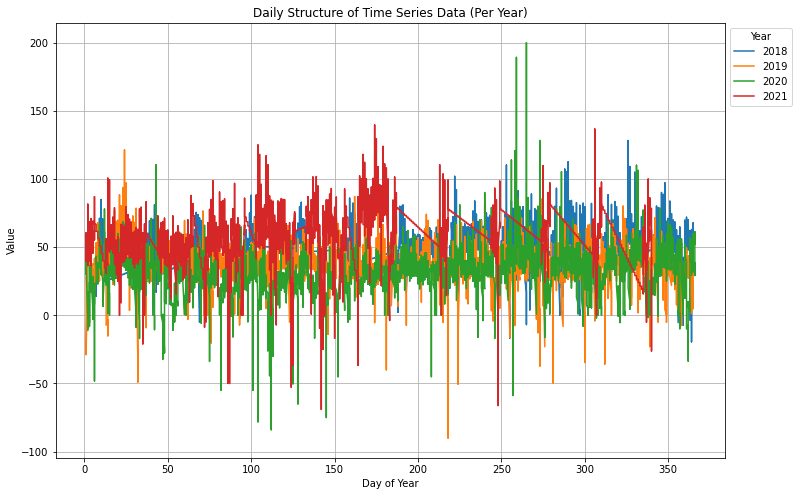

In [12]:
grouped = df.groupby(df.index.year)

# Plot daily structure for each year
plt.figure(figsize=(12, 8))
for year, group in grouped:
    plt.plot(group.index.dayofyear, group['Stromspotpreise Deutschland [EUR/MWh]'], label=str(year))

plt.xlabel('Day of Year')
plt.ylabel('Value')
plt.title('Daily Structure of Time Series Data (Per Year)')
plt.legend(title='Year', loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

Here one can see, that the Prices in 2021 have risen slightly above the values of previous years. And similarily prices in 2020 lie slightly under previous years.

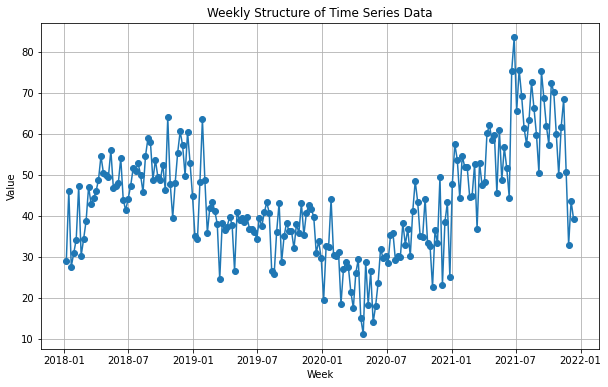

In [13]:
# Resample data to weekly frequency
df_weekly = df.resample('W').mean()  # You can use other aggregation methods like sum, median, etc., instead of mean

# Plot the weekly structure
plt.figure(figsize=(10, 6))
plt.plot(df_weekly.index, df_weekly['Stromspotpreise Deutschland [EUR/MWh]'], marker='o', linestyle='-')
plt.xlabel('Week')
plt.ylabel('Value')
plt.title('Weekly Structure of Time Series Data')
plt.grid(True)
plt.show()

The same trend can be seen here.

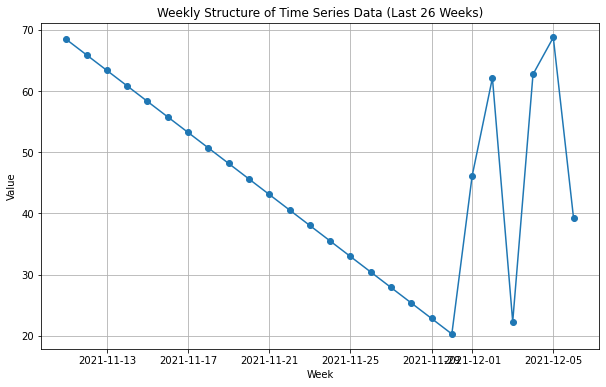

In [14]:
# Resample data to weekly frequency
df_weekly = df.resample('D').mean()  # You can use other aggregation methods like sum, median, etc., instead of mean

# Slice the DataFrame to include only the last 8 weeks of data
df_weekly_last_8_weeks = df_weekly.iloc[-26:]

# Plot the weekly structure for the last 8 weeks
plt.figure(figsize=(10, 6))
plt.plot(df_weekly_last_8_weeks.index, df_weekly_last_8_weeks['Stromspotpreise Deutschland [EUR/MWh]'], marker='o', linestyle='-')
plt.xlabel('Week')
plt.ylabel('Value')
plt.title('Weekly Structure of Time Series Data (Last 26 Weeks)')
plt.grid(True)
plt.show()

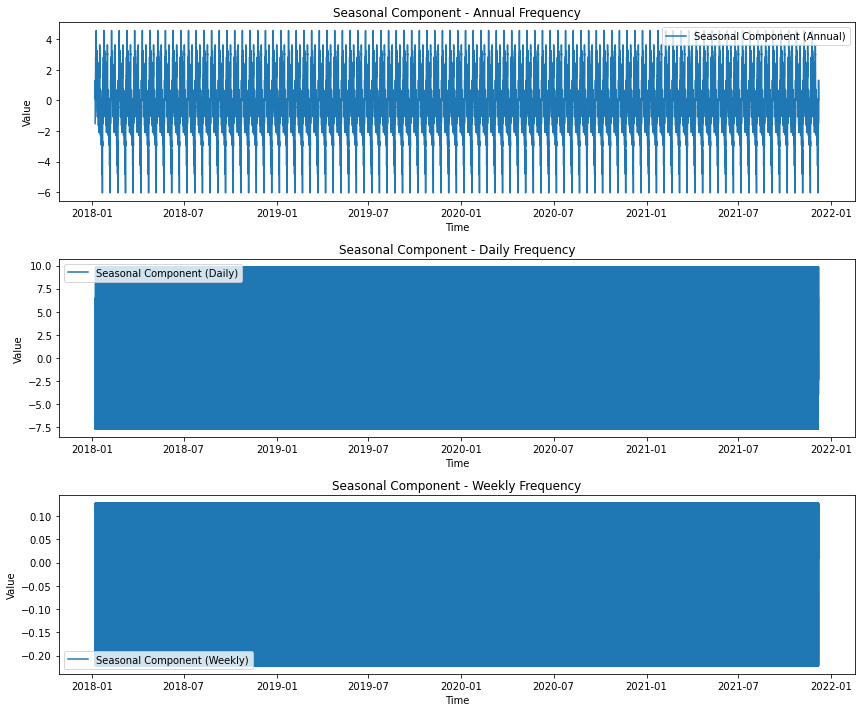

In [15]:


# Perform seasonal decomposition for annual, daily, and weekly frequencies
decomposition_annual = seasonal_decompose(df['Stromspotpreise Deutschland [EUR/MWh]'], model='additive', period=365)
decomposition_daily = seasonal_decompose(df['Stromspotpreise Deutschland [EUR/MWh]'], model='additive', period=24)  # Assuming hourly data
decomposition_weekly = seasonal_decompose(df['Stromspotpreise Deutschland [EUR/MWh]'], model='additive', period=7)

# Plot the decomposition results
plt.figure(figsize=(12, 10))

# Annual decomposition
plt.subplot(3, 1, 1)
plt.plot(decomposition_annual.seasonal, label='Seasonal Component (Annual)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Seasonal Component - Annual Frequency')
plt.legend()

# Daily decomposition
plt.subplot(3, 1, 2)
plt.plot(decomposition_daily.seasonal, label='Seasonal Component (Daily)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Seasonal Component - Daily Frequency')
plt.legend()

# Weekly decomposition
plt.subplot(3, 1, 3)
plt.plot(decomposition_weekly.seasonal, label='Seasonal Component (Weekly)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Seasonal Component - Weekly Frequency')
plt.legend()

plt.tight_layout()
plt.show()

Sadly no interesting results. Need to take a deeper look at the data to get more information out of it.

In [16]:
# # Calculate seasonal moving average
# window_size = 12  # Assuming a yearly seasonality (12 months)
# df['seasonal_ma'] = df['Stromspotpreise Deutschland [EUR/MWh]'].rolling(window=window_size, min_periods=1).mean()

# # Plot seasonal trend
# plt.figure(figsize=(10, 6))
# plt.plot(df.index, df['Stromspotpreise Deutschland [EUR/MWh]'], label='Original Data')
# plt.plot(df.index, df['seasonal_ma'], label=f'Seasonal Moving Average ({window_size} months)')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Seasonal Trend Detection')
# plt.legend()
# plt.show()

# Correlations

We will look at the correlation coefficients, to see if production of certain energy types significantly impacts the prices.

In [17]:
# Select the column for which you want to calculate correlations
column_of_interest = 'Stromspotpreise Deutschland [EUR/MWh]'

Ende Stunde                                        8019
Stromspotpreise Deutschland [EUR/MWh]                 0
CO2 Preise [EUR/t]                                 8019
Gasspotpreise Deutschland [EUR/MWh]                8019
Stromverbrauch Deutschland [MW]                    8019
Stromerzeugung Deutschland - Biomasse [MW]         8019
Stromerzeugung Deutschland - Braunkohle [MW]       8019
Stromerzeugung Deutschland - Gas [MW]              8019
Stromerzeugung Deutschland - Steinkohle[MW]        8019
Stromerzeugung Deutschland - Wasserkraft [MW]      8019
Stromerzeugung Deutschland - Nuklear [MW]          8019
Stromerzeugung Deutschland - Solar [MW]            8019
Stromerzeugung Deutschland - Wind Offshore [MW]    8019
Stromerzeugung Deutschland - Wind Onshore [MW]     8019
dtype: int64


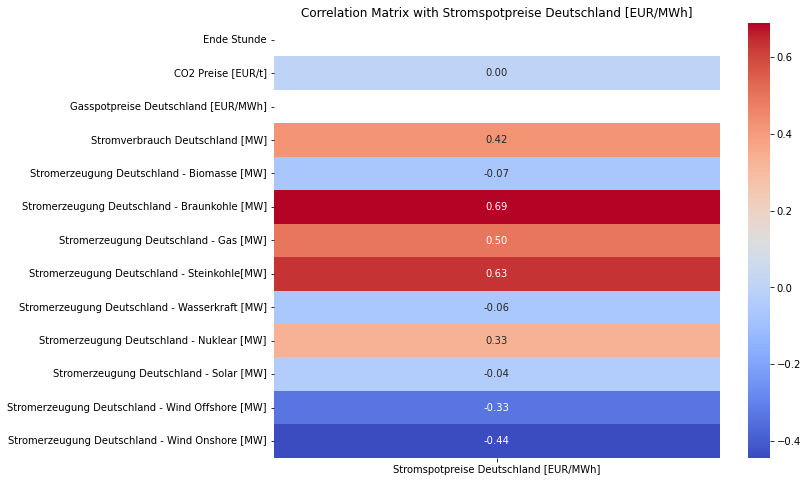

In [18]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Convert columns to numeric data types
df = df.apply(pd.to_numeric, errors='coerce')

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Extract correlations of the column of interest with all other columns
correlations_with_column = correlation_matrix[[column_of_interest]].drop(column_of_interest)

# Generate heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_with_column, annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f'Correlation Matrix with {column_of_interest}')
plt.show()


To get some better Results we do this for each year.

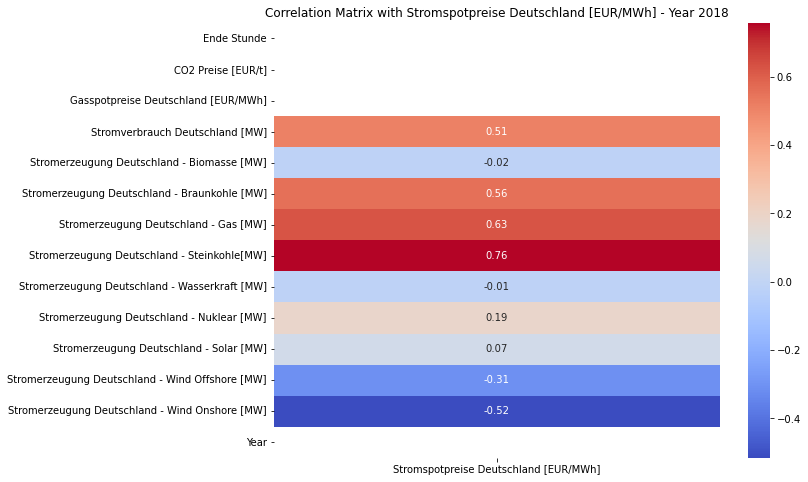

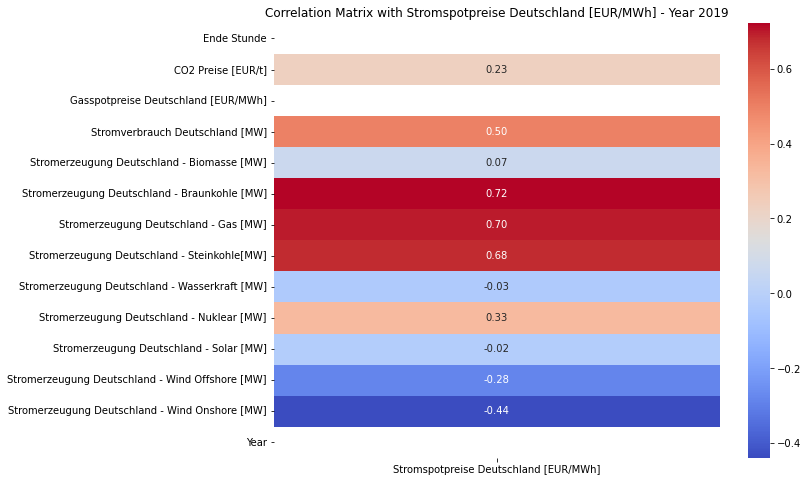

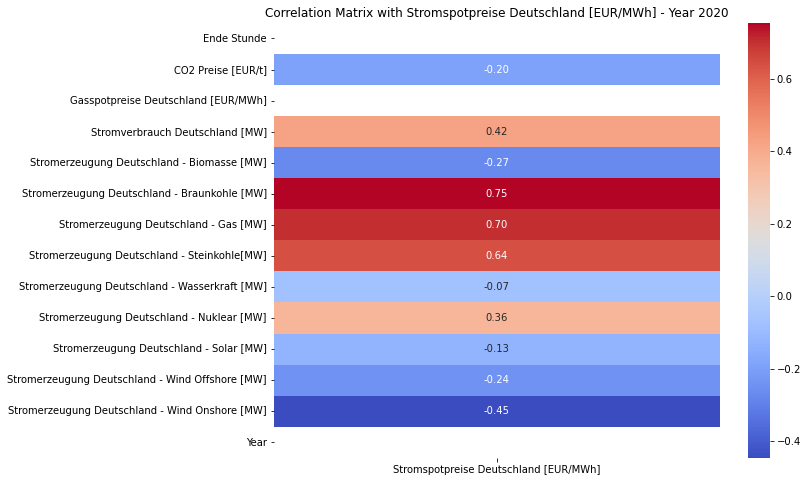

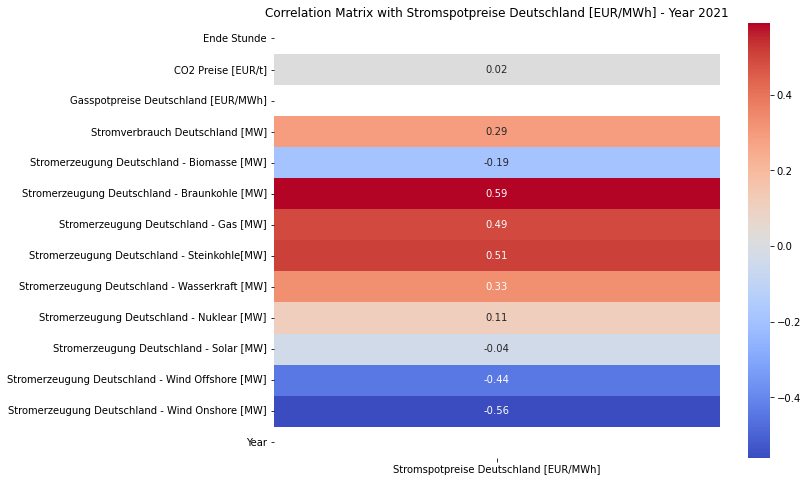

In [19]:
# Extract year from the index
df['Year'] = df.index.year

# Group DataFrame by year
grouped_df = df.groupby('Year')

# Iterate over groups and calculate correlation matrix for each year
for year, group_df in grouped_df:
    # Calculate the correlation matrix
    correlation_matrix = group_df.corr()
    
    # Select the column for which you want to calculate correlations
    column_of_interest = 'Stromspotpreise Deutschland [EUR/MWh]'
    
    # Extract correlations of the column of interest with all other columns
    correlations_with_column = correlation_matrix[[column_of_interest]].drop(column_of_interest)
    
    # Generate heatmap for each year
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations_with_column, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix with {column_of_interest} - Year {year}')
    plt.show()

One can see that the Impact of Production of Steinkohle has decreased in the Year of 2021. I wpuld like to plot these values, to see a yearly increase or decrease for each Attribute.

Now i would take a finer look at correlation coefficients depending on time. But i am missing the time now.